The notebook is an analysis of Fluminense's chances of relegation in the last round of the 2024 Brasileirão. The analysis is based on the probabilities of Fluminense winning, tying, or losing, as well as the probabilities of Atlético Paranaense, Atlético Mineiro, and Red Bull Bragantino winning, tying, or losing. The probabilities are based on the moneyline odds of each outcome.

The analysis was inspired by the following visual: 

![image](assets/cenarios-rebaixamento.avif)

Source: [Globo Esporte](https://ge.globo.com/futebol/times/fluminense/noticia/2024/12/07/fluminense-tem-duas-chances-de-queda-em-27-cenarios-veja-riscos-para-bragantino-athletico-e-galo.ghtml)

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
def plot(df, **kwargs):
    ax = df.plot(
        kind="bar",
        title="Relegation Chances", 
        xlabel="Team",
        ylabel="Probability",
        **kwargs
    )
    for idx in range(len(ax.containers)):
        plt.bar_label(ax.containers[idx])
    plt.show()
    

In [3]:
data = {
    "CAP": [
        *["Win"] * 9, *["Tie"] * 9, *["Loss"] * 9
    ],
    "CAM": [
        *["Loss"] * 9, *["Tie"] * 9, *["Win"] * 9
    ],
    "RBB": [
        *["Win"] * 3, *["Tie"] * 3, *["Loss"] * 3
    ] * 3,
    "FLU": [
        "Win", "Tie", "Loss"
    ] * 9,
    "Relegated": [
        *["CAM"] * 2, "FLU", *["RBB"] * 6, *["CAP"] * 2, "FLU", *["RBB"] * 6, *["CAP"] * 3, *["RBB"] * 6
    ],
}
df = pd.DataFrame(data, )
df

,CAP,CAM,RBB,FLU,Relegated
0,Win,Loss,Win,Win,CAM
1,Win,Loss,Win,Tie,CAM
2,Win,Loss,Win,Loss,FLU
3,Win,Loss,Tie,Win,RBB
4,Win,Loss,Tie,Tie,RBB
5,Win,Loss,Tie,Loss,RBB
6,Win,Loss,Loss,Win,RBB
7,Win,Loss,Loss,Tie,RBB
8,Win,Loss,Loss,Loss,RBB
9,Tie,Tie,Win,Win,CAP


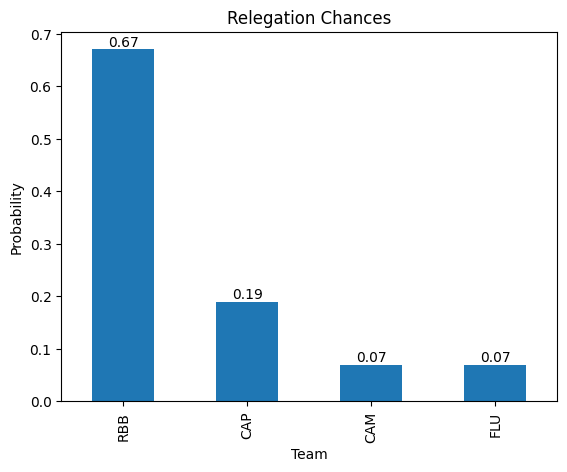

In [4]:
simple_chances = (df["Relegated"].value_counts() / len(df)).round(2)
simple_chances = simple_chances.rename("Probability")
plot(simple_chances)

In [5]:
def moneyline_to_prob(odd):
    """Converts american (moneyline) betting odd of an outcome to probability"""
    if odd > 0:
        result = 100 / (100 + odd)
    else:
        result = -odd / (-odd + 100)
    return round(result, 2)

# From DraftKings because Brazilian betting sites are blocked where I am
_moneylines = {
    "CAP": {
        "Win": 285,
        "Tie": 205,
        "Loss": 110
    },
    "CAM": {
        "Win": 110,
        "Tie": 205,
        "Loss": 285
    },
    "RBB": {
        "Win": -240,
        "Tie": 370,
        "Loss": 650
    },
    "FLU": {
        "Win": 600,
        "Tie": 360,
        "Loss": -230
    },
}

probabilities = {
    team: {outcome: moneyline_to_prob(odd) for outcome, odd in odds.items()}
    for team, odds in _moneylines.items()
}
probabilities

{'CAP': {'Win': 0.26, 'Tie': 0.33, 'Loss': 0.48},
 'CAM': {'Win': 0.48, 'Tie': 0.33, 'Loss': 0.26},
 'RBB': {'Win': 0.71, 'Tie': 0.21, 'Loss': 0.13},
 'FLU': {'Win': 0.14, 'Tie': 0.22, 'Loss': 0.7}}

In [6]:
prob_df = pd.DataFrame()

for col in df.columns:
    if col == "Relegated":
        prob_df["Relegated"] = df[col]
        continue
    prob_df[f"{col}_prob"] = df[col].apply(lambda x: probabilities[col][x])

prob_df["Weighted Probability"] = (
    prob_df["CAP_prob"] * prob_df["CAM_prob"] * prob_df["RBB_prob"] * prob_df["FLU_prob"]
)
team_prob = prob_df.groupby('Relegated')['Weighted Probability'].sum()
# normalize to 1
team_prob = (team_prob / team_prob.sum()).round(2)
team_prob

Relegated
CAM    0.04
CAP    0.44
FLU    0.19
RBB    0.32
Name: Weighted Probability, dtype: float64

In [7]:
probabilities_df = pd.merge(simple_chances, team_prob, left_index=True, right_index=True)

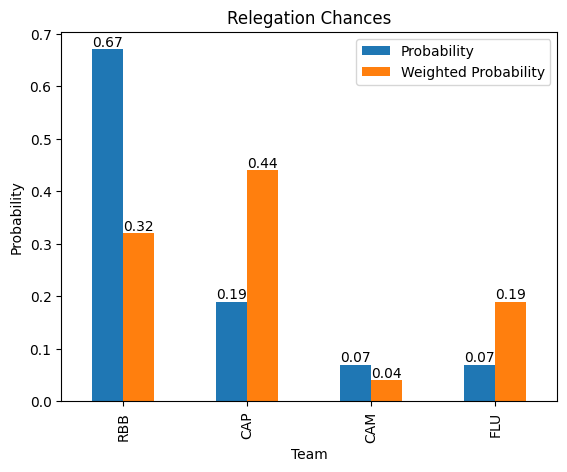

In [8]:
plot(probabilities_df)